In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D #library for 3D-plot

## Bayesian decision theory와 Classification (분류)

#### Bayes' rule

## $P( \omega_j | \mathbf{x} ) = \frac{p(\mathbf{x} | \omega_j) P(\omega_j)}{p(\mathbf{x})} = \frac{p(\mathbf{x} | \omega_j) P(\omega_j)}{\sum_{k}{p(\mathbf{x}|\omega_k)P(\omega_k)}}$

Bayesian decision theory는 분류(classification) 문제를 풀 때, 분류를 잘못할 확률 $P(error) = \int{p(error, \mathbf{x}) d\mathbf{x}} = \int{p(error | \mathbf{x}) p(\mathbf{x}) d\mathbf{x}}$ 을 낮추기 위해서 어떤 선택을 해야되는지에 대한 확률적인 해법을 제시한다. 이를 위해 가장 큰 사후확률(Posteriori probability)을 가진 $j$를 선택한다.

### [Exercise 1] Naive Bayes with 1D Gaussian distribution

모든 클래스의 사전확률(priori probability)이 동등하면, $P(\omega_1)=P(\omega_2)=...=P(\omega_N)$ 이므로, $p(\mathbf{x} | \omega_j)$만 비교하면 된다. 
분류 경계(Decision boundary) 그리기에 익숙해지기 위해 Exercise 1에서는 모든 클래스의 사전확률(priori probability)가 같다고 가정한다.

1차원 정규 분포 함수 
- $f(x; \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}}e^{ -\frac{(x-\mu)^2}{2 \sigma^2}} $ 

<font color='blue'>정규 분포 함수는 $\sigma^2$으로 표기됩니다. 이 부분을 다시 수정하였습니다. 하지만 인자 값을 넣어줄 때에는 라이브러리 함수마다 표준편차와 분산 중 요구하는 것이 다르기 때문에 함수 설명 문서를 살펴보는 것이 좋습니다. 이번 시간에 우리가 만든 gaussian_pdf 함수는 표준편차를 이용해 구현하였기 때문에, $\sigma^2$이 아닌, $\sigma$를 인자로 입력해주었습니다.</font>

In [34]:
# probability density function for 1D gaussian distribution
def gaussian_pdf(x, mu, sigma):
    # implement here
    x_whitened = (x-mu)/sigma
    return (np.exp(-(x_whitened**2/2))/(np.sqrt(2*np.pi)*sigma))

아래의 1차원 정규 분포를 시각화

- $x_1 \sim \mathcal{N}(\mu = 0, \sigma^2 = 1)$

- $x_2 \sim \mathcal{N}(\mu = 4, \sigma^2 = 1)$

아래 방정식을 만족하는 $x$는?

- $f(x; 0, 1) = f(x; 4, 1)$

<font color='blue'>x 값이 불연속적이기 때문에, pdf1과 pdf2가 정확히 일치하는 x가 없을 수 있다. 따라서 두 pdf 차의 범위를 좁혀 pdf1==pdf2와 거의 일치하는 값을 찾는다. np.where는 조건을 만족하는 index를 반환한다. https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html</font>

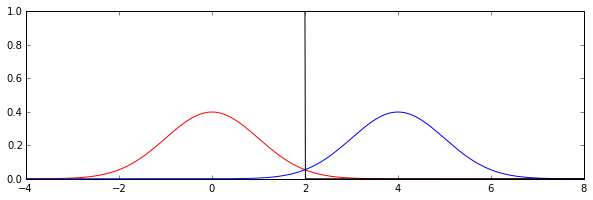

(array([600]),)
[ 2.]


In [35]:
xMin = -4
xMax = 8
xStepSize = 0.01
xVal = np.arange(xMin,xMax,xStepSize) # pdf 값을 출력할 x 값의 집합. 불연속적이다.

mu1 = 0
sigma1 = 1

mu2 = 4
sigma2 = 1

pdf1 = gaussian_pdf(xVal, mu1, sigma1)
pdf2 = gaussian_pdf(xVal, mu2, sigma2)

plt.figure(figsize=(10,3))
plt.plot(xVal, pdf1, color='red')
plt.plot(xVal, pdf2, color='blue')
plt.plot(xVal, pdf1 > pdf2, color='black')
plt.show()

idx = np.where((np.abs(pdf1-pdf2)<0.0001)==1)
print idx
print xVal[idx]

아래의 1차원 정규 분포를 시각화

- $x_1 \sim \mathcal{N}(\mu = 0, \sigma = 1)$

- $x_2 \sim \mathcal{N}(\mu = 4, \sigma = 3)$

아래 방정식을 만족하는 $x$는?

- $f(x; 0, 1) = f(x; 4, 3)$

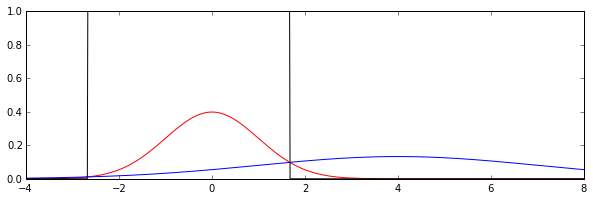

[-2.72 -2.71 -2.7  -2.69 -2.68 -2.67 -2.66 -2.65 -2.64 -2.63  1.67]


In [36]:
# 위 예제를 참고하여 구해보세요.
xMin = -4
xMax = 8
xStepSize = 0.01
xVal = np.arange(xMin,xMax,xStepSize)

mu1 = 0
sigma1 = 1

mu2 = 4
sigma2 = 3

pdf1 = gaussian_pdf(xVal, mu1, sigma1)
pdf2 = gaussian_pdf(xVal, mu2, sigma2)

plt.figure(figsize=(10,3))
plt.plot(xVal, pdf1, color='red')
plt.plot(xVal, pdf2, color='blue')
plt.plot(xVal, pdf1 > pdf2, color='black')
plt.show()

idx = np.where((np.abs(pdf1-pdf2)<0.001)==1)
print xVal[idx]

### [Exercise 2] Multivariate Normal distribution의 공분산(covariance)의 형태에 따른 분류 경계(decision boundary)의 모양

2차원의 정규 분포 확률 밀도 함수는 다음과 같다.

$f(\begin{bmatrix}x\\ y \end{bmatrix}) = \frac{1}{2\pi \sqrt{(\Sigma_{11} \Sigma_{22} - \Sigma_{12} \Sigma_{21})}}$ $exp \left( -\frac{1}{2}   \begin{bmatrix}x - \mu_1 & y - \mu_2 \end{bmatrix} \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix}^{-1} \begin{bmatrix}x - \mu_1 \\ y - \mu_2 \end{bmatrix} \right)$

### Discriminant Functions for the Normal Density

###  $p(\mathbf{x}|w_i)=\frac{1}{(2\pi)^\frac{d}{2} |\boldsymbol\Sigma_i|^\frac{1}{2}} e^{-\frac{1}{2} (\mathbf{x} -\boldsymbol{\mu}_i)^T \boldsymbol\Sigma_i^{-1} (\mathbf{x} -\boldsymbol{\mu}_i)}$
### $g_i(\mathbf{x}) = \ln p(\mathbf{x}|w_i) + \ln P(w_i)$


## case 1 :  $\boldsymbol\Sigma = \sigma^2\mathbf{I}$
### $g_i(\mathbf{x}) = -\frac{1}{2\sigma^2} \| \mathbf{x}-\boldsymbol{\mu_i} \| ^2 + \ln P(w_i)$
### $g_i(\mathbf{x}) = \mathbf{w}_i^T\mathbf{x} + w_{i0}$
### decision boundary =  {$\mathbf{x} | \mathbf{w}^T(\mathbf{x}-\mathbf{x_0})=0$}
### - $\mathbf{w} = \boldsymbol{\mu_i}-\boldsymbol{\mu_j}$
### - $\mathbf{x_0} = \frac{1}{2} (\boldsymbol{\mu_i}+\boldsymbol{\mu_j}) - \frac{\sigma^2}{\|\boldsymbol{\mu_i}-\boldsymbol{\mu_j}\|^2} \ln \frac{ P(w_i)}{P(w_j)} (\boldsymbol{\mu_i}-\boldsymbol{\mu_j})$
#### $P(w_i)=P(w_j)$ 라고 가정하면,
### - $\mathbf{x_0} = \frac{1}{2} (\boldsymbol{\mu_i}+\boldsymbol{\mu_j}) $


In [55]:
def visualize_decision_boundary(mu1, mu2, cov1, cov2):
    # use 'plt.matshow'
    from scipy.stats import multivariate_normal

    var1 = multivariate_normal(mean=mu1, cov=cov1)
    var2 = multivariate_normal(mean=mu2, cov=cov2)

    minVal   = -10
    maxVal   = 10
    stepSize = 0.05
    xAxisVal = np.arange(minVal, maxVal, stepSize)
    yAxisVal = np.arange(minVal, maxVal, stepSize)
    xx, yy = np.meshgrid(xAxisVal, yAxisVal)

    
    surfvar1 = plt.contour(xx,yy,var1.pdf(np.stack([xx,yy],2)))  
    surfvar2 = plt.contour(xx,yy,var2.pdf(np.stack([xx,yy],2)))  
    surf = plt.contour(xx,yy,var1.pdf(np.stack([xx,yy], 2))>var2.pdf(np.stack([xx,yy], 2)))
                   
    surfg = plt.plot(xAxisVal, g(xAxisVal, mu1,mu2,cov1), '--')
    
    plt.colorbar(shrink=0.5, aspect=3)

<font color='blue'> np stack은 모양이 같은 두 array를 기준 축을 따라 묶어주는 역할을 합니다. 아래 예시를 참고하세요. plt.contour에서는 x, y 좌표를 묶어주는 역할을 합니다. 이를 바탕으로 pdf 값을 구하게 됩니다.  https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html</font>

In [49]:
x = np.arange(1, 3, 1)
y = np.arange(4, 7, 1)

print "x"
print x
print "y"
print y

xx, yy = np.meshgrid(x, y)

print "xx"
print xx
print "yy"
print yy
print "stack_1"
print np.stack([xx,yy],1)  
print "stack_2"
print np.stack([xx,yy],2)  


x
[1 2]
y
[4 5 6]
xx
[[1 2]
 [1 2]
 [1 2]]
yy
[[4 4]
 [5 5]
 [6 6]]
stack_1
[[[1 2]
  [4 4]]

 [[1 2]
  [5 5]]

 [[1 2]
  [6 6]]]
stack_2
[[[1 4]
  [2 4]]

 [[1 5]
  [2 5]]

 [[1 6]
  [2 6]]]


### (1) $\Sigma_i = \sigma^2 I$ : 단위행렬(Identity Matrix)에 상수가 곱해져있는 형태일 때 ($P(w_i)=P(w_j)$가정)

### decision boundary를 그리는 함수
### - $ \mathbf{w}^T(\mathbf{x}-\mathbf{x_0})=0 \rightarrow y=a*x+b$ 이 형태로 바꾸어서 plot

$ \begin{bmatrix}w_0\\ w_1 \end{bmatrix}^T(\begin{bmatrix}x\\ y \end{bmatrix}-\begin{bmatrix}x_{00}\\ x_{01} \end{bmatrix})= w_0(x-x_{00}) + w_1(y-x_{01})=0$

$(y-x_{01})=-w_0/w_1(x-x_{00})$

$y=-w_0/w_1x+w_0x_{00}/w_1  + x_{01}$


In [53]:
def g(xx, mu1, mu2, sigma):
  # create decision boundary
  w = (mu1-mu2)
  x0 = (mu1+mu2)/2

  a = -w[0]/w[1]
  b = w[0]*x0[0]/w[1]+x0[1]  
  return  a*xx + b

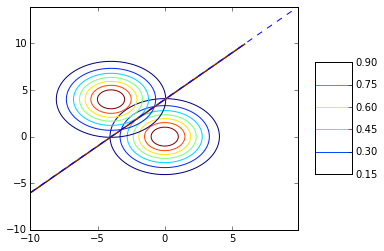

In [56]:
mu1 = np.array([0,0])
mu2 = np.array([-4,4])
sigma = 2
cov = (sigma*sigma) * np.eye(2) # Identity matrix

visualize_decision_boundary(mu1, mu2, cov, cov)

### (2) $\Sigma_i = \Sigma$ : 모든 공분산이 같을 때 (공분산의 형태는 자유)

## case 2 :  $\boldsymbol\Sigma_i = \Sigma$
### $g_i(\mathbf{x}) = -\frac{1}{2} (\mathbf{x}-\boldsymbol{\mu_i})^T \Sigma^{-1} (\mathbf{x}-\boldsymbol{\mu_i}) + \ln P(w_i)$
### decision boundary =  {$\mathbf{x} | \mathbf{w}^T(\mathbf{x}-\mathbf{x_0})=0$}
### - $\mathbf{w} = \Sigma^{-1}(\boldsymbol{\mu_i}-\boldsymbol{\mu_j})$
### - $\mathbf{x_0} = \frac{1}{2} (\boldsymbol{\mu_i}+\boldsymbol{\mu_j}) - \frac{1}{(\boldsymbol{\mu_i}-\boldsymbol{\mu_j})^T \Sigma^{-1} (\boldsymbol{\mu_i}-\boldsymbol{\mu_j})} \ln \frac{ P(w_i)}{P(w_j)} (\boldsymbol{\mu_i}-\boldsymbol{\mu_j})$

np.linalg.inv : inverse matrix를 만들어주는 함수
https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html

In [57]:
def g(xx, mu1, mu2, Sigma):
  # create decision boundary
  iSigma = np.linalg.inv(Sigma)
      
  submuij = mu1-mu2
  summuij = mu1+mu2
  invsubmuij = np.matmul(submuij, iSigma)
    
  a = -invsubmuij[0]/invsubmuij[1]
  b = np.dot(invsubmuij,summuij)/(2*invsubmuij[1]) 
  return  a*xx + b

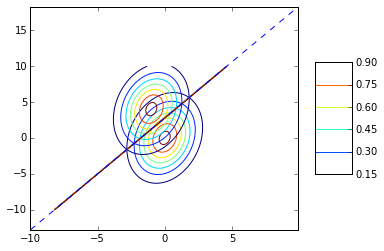

In [58]:
mu1 = np.array([0,0])
mu2 = np.array([-1,4])
cov = np.array([[2, 1], [1, 10]])

visualize_decision_boundary(mu1, mu2, cov, cov)

### (3) $\Sigma_i = $ : 임의의 공분산에 대해; arbitrary (positive-semi definite matrix)

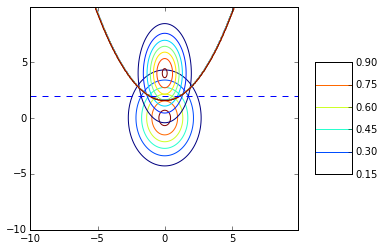

In [59]:
mu1 = np.array([0,0])
mu2 = np.array([0,4])
cov1 = np.array([[2, 1], [0, 5]])
cov2 = np.array([[1, 0], [0, 5]])

visualize_decision_boundary(mu1, mu2, cov1, cov2)

## [Exercise 3] Salmon, Bass Classification

물고기의 길이 $x_0$, 무게 $x_1$가 주어졌을 때, 고등어 구분해보자.

100개의 물고기 중 10마리는 연어였고, 30마리는 농어, 60마리는 고등어였다.

$P([x_0,x_1]|\omega_1) \sim \mathcal{N}(\mu = [20, 60], \sigma = [5, 2])$

$P([x_0,x_1]|\omega_2) \sim \mathcal{N}(\mu = [40, 50], \sigma = [2, 4])$

$P([x_0,x_1]|\omega_3) \sim \mathcal{N}(\mu = [15, 40], \sigma = [3, 3])$

연어($\omega_1$)의 길이와 농어($\omega_2$)의 길이는 위 정규분포를 따른다고 할 때,
Exercise 1과 같이 그래프를 그리고, Decision boundary를 나타내시오.

In [100]:
def visualize_decision_boundary2(mu1, mu2, mu3, cov1, cov2, cov3):
    # use 'plt.matshow'
    from scipy.stats import multivariate_normal

    var1 = multivariate_normal(mean=mu1, cov=cov1)
    var2 = multivariate_normal(mean=mu2, cov=cov2)
    var3 = multivariate_normal(mean=mu3, cov=cov3)

    stepSize = 0.05
    xAxisVal = np.arange(10, 50, stepSize)
    yAxisVal = np.arange(30, 70, stepSize)
    xx, yy = np.meshgrid(xAxisVal, yAxisVal)

    z1 = var1.pdf(np.stack([xx,yy],2)) * 0.1
    z2 = var2.pdf(np.stack([xx,yy],2)) * 0.3
    z3 = var3.pdf(np.stack([xx,yy],2)) * 0.6
    surfvar1 = plt.contour(xx,yy,z1)  
    surfvar2 = plt.contour(xx,yy,z2)  
    surfvar3 = plt.contour(xx,yy,z3)  
    surf1 = plt.contour(xx,yy,z1>np.maximum(z2,z3))
    surf2 = plt.contour(xx,yy,z2>np.maximum(z1,z3))
    surf3 = plt.contour(xx,yy,z3>np.maximum(z1,z2))
    
    plt.colorbar(shrink=0.5, aspect=3)

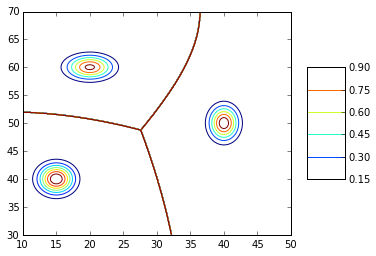

In [101]:
mu1 = np.array([20,60])
mu2 = np.array([40,50])
mu3 = np.array([15,40])
cov1 = np.array([[5, 0], [0, 2]])
cov2 = np.array([[2, 0], [0, 4]])
cov3 = np.array([[3, 0], [0, 3]])

visualize_decision_boundary2(mu1, mu2, mu3, cov1, cov2, cov3)

## 3D graph로 나타내기
PR03에서 배운 내용을 이용하면 3D plot으로 나타낼 수 있습니다.

In [106]:
def visualize_decision_boundary_3D(mu1, mu2, mu3, cov1, cov2, cov3):
    # use 'plt.matshow'
    from mpl_toolkits.mplot3d import Axes3D #library for 3D-plot

    var1 = multivariate_normal(mean=mu1, cov=cov1)
    var2 = multivariate_normal(mean=mu2, cov=cov2)
    var3 = multivariate_normal(mean=mu3, cov=cov3)

    stepSize = 0.05
    xAxisVal = np.arange(10, 50, stepSize)
    yAxisVal = np.arange(30, 70, stepSize)
    xx, yy = np.meshgrid(xAxisVal, yAxisVal)

    fig = plt.figure(figsize=(10,7))
    ax = fig.gca(projection='3d')
    
    z1 = var1.pdf(np.stack([xx,yy],2)) * 0.1
    z2 = var2.pdf(np.stack([xx,yy],2)) * 0.3
    z3 = var3.pdf(np.stack([xx,yy],2)) * 0.6
    surfvar1 = ax.plot_surface(xx,yy,z1, cmap=cm.coolwarm, linewidth=0, alpha=0.6)  
    surfvar2 = ax.plot_surface(xx,yy,z2, cmap=cm.coolwarm, linewidth=0, alpha=0.6)  
    surfvar3 = ax.plot_surface(xx,yy,z3, cmap=cm.coolwarm, linewidth=0, alpha=0.6)  
    surf1 = plt.contour(xx,yy,0.01*(z1>np.maximum(z2,z3)))
    surf2 = plt.contour(xx,yy,0.01*(z2>np.maximum(z1,z3)))
    surf3 = plt.contour(xx,yy,0.01*(z3>np.maximum(z1,z2)))

    fig.colorbar(surf, shrink=0.5, aspect=3)
    plt.show()

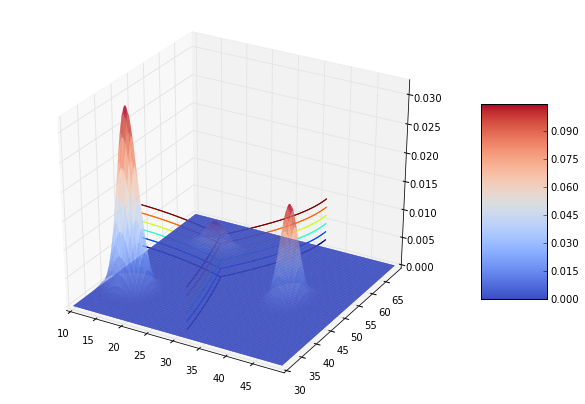

In [107]:
mu1 = np.array([20,60])
mu2 = np.array([40,50])
mu3 = np.array([15,40])
cov1 = np.array([[5, 0], [0, 2]])
cov2 = np.array([[2, 0], [0, 4]])
cov3 = np.array([[3, 0], [0, 3]])

visualize_decision_boundary_3D(mu1, mu2, mu3, cov1, cov2, cov3)